In [0]:
# import libraries
import torch as th
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

#Load and Visualize the Data

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0

# how many samples for batch to load - Q: Try with different batch size to see effects
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to Torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# define train and test datasets - define the root as 'data'
train_set = datasets.MNIST(root='data', train=True,  download=True, transform=transform)
test_set = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# define loaders that load the data
train_loader = th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
valid_loader = th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = th.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 9267288.43it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 137709.83it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2245654.61it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49616.16it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


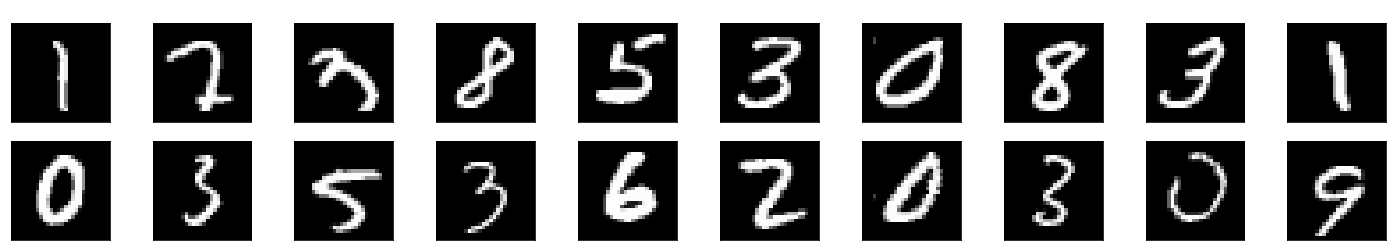

In [5]:
# visualise the loaded data
import matplotlib.pyplot as plot

# get one batch of train images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot images and labels in the batch 
fig = plot.figure(figsize=(25, 4))

for indx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, indx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[indx]), cmap='gray') 
  ax.set_title(str(labels[indx].item()), color='white')
  

#Define the Network  Architecture

In [6]:
from torch import nn
import torch.nn.functional as F

# define model network clas
class Network(nn.Module):
  
  # include all layers on __init__()
  def __init__(self):
    # call super __init_()
    super(Network, self).__init__()
    
    # 3 fully connected Layer hidden and output
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)
    
    # dropout to prevent overfitting 
    self.dropout = nn.Dropout(0.2)
    
    # define forward behavior of network - that is how the input x 
    #is going to be passed to layers and transformed
    
  def forward(self, x):
    # flatten input
#       x = x.view(-1, 28 * 28)
      
      # pass input to the layers
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      x = F.log_softmax(x, dim=1)
      
      return x      
      
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [7]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[-0.0110, -0.0340, -0.0066,  ..., -0.0229,  0.0295, -0.0178],
        [ 0.0118, -0.0288, -0.0227,  ..., -0.0233,  0.0236, -0.0260],
        [ 0.0120, -0.0283, -0.0127,  ...,  0.0351,  0.0342,  0.0339],
        ...,
        [-0.0248,  0.0175,  0.0310,  ...,  0.0278, -0.0346,  0.0073],
        [ 0.0209, -0.0330,  0.0062,  ..., -0.0020,  0.0012,  0.0218],
        [ 0.0357,  0.0269,  0.0275,  ..., -0.0269,  0.0161,  0.0250]],
       requires_grad=True)
Parameter containing:
tensor([-0.0017, -0.0070,  0.0347, -0.0240,  0.0259,  0.0261,  0.0291, -0.0274,
         0.0061,  0.0061, -0.0275, -0.0139, -0.0200,  0.0287, -0.0123, -0.0050,
        -0.0300,  0.0290,  0.0140, -0.0143, -0.0079, -0.0054, -0.0267,  0.0059,
        -0.0308, -0.0320,  0.0329,  0.0332, -0.0292,  0.0150,  0.0074,  0.0294,
         0.0323, -0.0237,  0.0122,  0.0041,  0.0009, -0.0164, -0.0251,  0.0157,
        -0.0092,  0.0249,  0.0265,  0.0013, -0.0173,  0.0129, -0.0130,  0.0325,
        -0.0062

In [0]:
from torch import optim
# define loss
criterion = nn.NLLLoss()
# define optimizer Q. useful use alternative optimizers for this kind of data?
opt = optim.SGD(model.parameters(), lr=0.01)

#Train the Network

In [7]:
# times the model sees all entries all training data heare all images are seen 60 times
epochs = 60

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

#model.train()

train_losses, valid_losses = [], []

for e in range(epochs):
  
  train_loss = 0.0
  valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    
  model.train()  
  for images, labels in train_loader:
    images = images.view(images.shape[0], -1)
    
    opt.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()    
    opt.step()
    
    #accumulate loss from each batch
    train_loss += loss.item()*images.size(0)
    
    ######################    
    # validate the model #
    ######################
  model.eval()     
  for images, labels in valid_loader:
    
    images = images.view(images.shape[0], -1)
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model.forward(images)
    # calculate the loss
    loss = criterion(output, labels)
    # update running validation loss 
    valid_loss += loss.item()*images.size(0)
  
  # print training/validation statistics 
  # calculate average loss over an epoch
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
  
  
  train_losses.append(train_loss/len(train_loader.sampler))
  valid_losses.append(valid_loss/len(valid_loader.sampler))
  
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min and (valid_loss_min - valid_loss) > 0.05:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    th.save(model.state_dict(), 'model.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.314246 	Validation Loss: 0.600838
Validation loss decreased (inf --> 0.600838).  Saving model ...
Epoch: 2 	Training Loss: 0.547838 	Validation Loss: 0.404959
Validation loss decreased (0.600838 --> 0.404959).  Saving model ...
Epoch: 3 	Training Loss: 0.433435 	Validation Loss: 0.328665
Validation loss decreased (0.404959 --> 0.328665).  Saving model ...
Epoch: 4 	Training Loss: 0.375586 	Validation Loss: 0.292487
Epoch: 5 	Training Loss: 0.333926 	Validation Loss: 0.269359
Validation loss decreased (0.328665 --> 0.269359).  Saving model ...
Epoch: 6 	Training Loss: 0.312713 	Validation Loss: 0.246191
Epoch: 7 	Training Loss: 0.279591 	Validation Loss: 0.221821
Epoch: 8 	Training Loss: 0.263137 	Validation Loss: 0.199761
Validation loss decreased (0.269359 --> 0.199761).  Saving model ...
Epoch: 9 	Training Loss: 0.243613 	Validation Loss: 0.182286
Epoch: 10 	Training Loss: 0.224358 	Validation Loss: 0.165949
Epoch: 11 	Training Loss: 0.207228 	Validation Lo

##Load the Model with the Lowest Validation Loss

In [0]:
model.load_state_dict(th.load('model.pt'))

In [0]:
# Copy Udacity's helper file in a cell
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.set_aspect("auto")
    
    ax2.bar(np.arange(10), ps)
    
    fig.tight_layout()
    ax1.axis('off')
    
    ax2.set_xticks(np.arange(10))
    if version == "MNIST":
        ax2.set_xticklabels(np.arange(10), color='white')
        ax2.tick_params(labelcolor='white')
    elif version == "Fashion":
        ax2.set_xticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability', color='white')
    ax2.set_ylim(0, 1.1)
    plt.tight_layout()


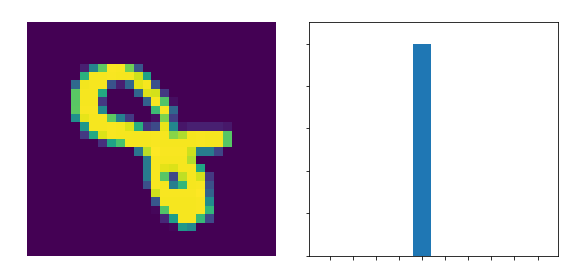

In [0]:
# get an image from test_loader and pass it through model for prediction
images, labels = next(iter(test_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with th.no_grad():
    logps = model.forward(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = th.exp(logps)
view_classify(img.view(1, 28, 28), ps)

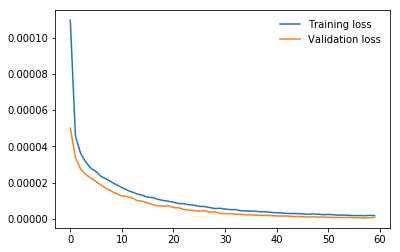

In [10]:
plot.plot(train_losses, label='Training loss')
plot.plot(valid_losses, label='Validation loss')
plot.legend(frameon=False)

#Test the Network

In [0]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
# create lists to hold values for the total classes and correctly predicted classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for images, labels in test_loader:
  # flatten images
  images = images.view(images.shape[0], -1)
  output = model.forward(images)
  
  loss = criterion(output, labels)
  test_loss += loss.item()*images.size(0)
  
  # convert output probabilities to predicted class
  _, preds = th.max(output, 1)
  
  # compare predictions to true label
  correct = np.squeeze(preds.eq(labels.data.view_as(preds)))
#   print(correct)
  
  # calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
#     print(label)
    class_correct[label] += correct[i].item()
    class_total[label] += 1
    
    # calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
  

##Statistics - Training results

* 3 sets - 60 Epochs - 2 dropouts - lr=0.01


Test Loss: 0.124382

--------------------------------------------------------------------------------------------------------

Test Accuracy of     0: 98% (966/980)

Test Accuracy of     1: 98% (1121/1135)

Test Accuracy of     2: 96% (992/1032)

Test Accuracy of     3: 95% (965/1010)

Test Accuracy of     4: 94% (931/982)

Test Accuracy of     5: 95% (852/892)

Test Accuracy of     6: 96% (925/958)

Test Accuracy of     7: 96% (994/1028)

Test Accuracy of     8: 93% (911/974)

Test Accuracy of     9: 95% (963/1009)

----------------------------------------------------------------------------------------------------

Test Accuracy (Overall): 96% (9620/10000)